In [29]:
!{sys.executable} -m pip install seaborn

In [30]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils, zscores
from utils import plotting_utils as pu
from utils import auc_methods as am
import matplotlib.patches as patches
from matplotlib import gridspec
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from matplotlib_venn import venn2
import seaborn as sns

%load_ext autoreload
%autoreload 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
size_mult = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

In [7]:
DATA_DIR = os.path.abspath('../data')
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_processed_02-28-2019.h5'), 'fixed')
unit_key_df = pd.read_hdf(os.path.join(DATA_DIR, 'unit_key_df_processed_02-28-2019.h5'), 'fixed')

In [20]:
sub_map

,uni_id,mouse_name,date,cluster_name,RT_mean_TLR,RT_mean_VLL,RT_median_TLR,RT_median_VLL,RT_std_TLR,RT_std_VLL,...,cp_onset_touch_LR_dp,area_under_cp_visual_LL_dp,max_cp_visual_LL_dp,cp_onset_visual_LL_dp,area_under_cp_touch_stim_sp,max_cp_touch_stim_sp,cp_onset_touch_stim_sp,area_under_cp_visual_stim_sp,max_cp_visual_stim_sp,cp_onset_visual_stim_sp
0,07401-03-161t1,EF0074,01-03-16,TT1clst1,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,0.244836,0.597762,NaN,0.077278,0.556132,NaN,-0.017950,0.575692,NaN
1,07401-03-162t1,EF0074,01-03-16,TT2clst1,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,-1.133391,0.547332,0.55,-0.012880,0.517686,NaN,-0.146410,0.489619,NaN
2,07401-03-162t2,EF0074,01-03-16,TT2clst2,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,0.884854,0.663511,NaN,0.153018,0.563245,NaN,-0.075260,0.624567,NaN
3,07401-03-165t1,EF0074,01-03-16,TT5clst1,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,0.844923,0.605336,NaN,-0.097078,0.511342,NaN,0.152682,0.647059,NaN
4,07401-03-165t2,EF0074,01-03-16,TT5clst2,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,-0.655508,0.612909,NaN,-0.028739,0.544983,NaN,0.001730,0.592128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,11406-01-187t1,EF0114,06-01-18,TT7clst1,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,0.743171,0.607255,NaN,0.056793,0.559533,NaN,0.083333,0.666667,NaN
1535,11406-01-187t2,EF0114,06-01-18,TT7clst2,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,0.292264,0.576803,NaN,0.012053,0.539445,NaN,0.055556,0.666667,NaN
1536,11406-01-187t3,EF0114,06-01-18,TT7clst3,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,-0.094996,0.561464,NaN,0.018444,0.562820,NaN,0.430556,0.750000,NaN
1537,11406-01-188t1,EF0114,06-01-18,TT8clst1,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,0.548142,0.578370,NaN,0.031958,0.554785,NaN,0.222222,0.666667,NaN


In [8]:
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
unit_key_df['mouse_name'].unique()

array(['EF0089', 'EF0114', 'EF0079', 'EF0074', 'EF0088', 'EF0077',
       'EF0084', 'EF0081', 'EF0076'], dtype=object)

In [12]:
tactile_lick_noLick_aucs = pd.read_hdf(os.path.join(DATA_DIR, 'Touch_lick_no_lick_auc_2019-02-27.h5'), 'table')
visual_lick_noLick_aucs = pd.read_hdf(os.path.join(DATA_DIR, 'Visual_lick_no_lick_auc_2019-02-27.h5'), 'table')
stim_prob_aucs = pd.read_hdf(os.path.join(DATA_DIR, 'Touch_stim_prob_auc_2019-02-24.h5'), 'table')

tactile_lick_noLick_aucs = tactile_lick_noLick_aucs[tactile_lick_noLick_aucs['uni_id'].isin(unit_key_df['uni_id'])]
visual_lick_noLick_aucs = visual_lick_noLick_aucs[visual_lick_noLick_aucs['uni_id'].isin(unit_key_df['uni_id'])]
stim_prob_aucs = stim_prob_aucs[stim_prob_aucs['uni_id'].isin(unit_key_df['uni_id'])]

In [13]:
tactile_lick_noLick_aucs = tactile_lick_noLick_aucs.reset_index(drop = True)
visual_lick_noLick_aucs = visual_lick_noLick_aucs.reset_index(drop = True)
stim_prob_aucs = stim_prob_aucs.sort_values('uni_id').reset_index(drop=True)
unit_key_df = unit_key_df.sort_values('uni_id').reset_index(drop = True)

In [14]:
up_cols = stim_prob_aucs.columns[stim_prob_aucs.columns.str.contains('up')]
down_cols = stim_prob_aucs.columns[stim_prob_aucs.columns.str.contains('low')]
auc_cols = stim_prob_aucs.columns[stim_prob_aucs.columns.str.contains('auc')]

up_95_conf_int = stim_prob_aucs[np.append('uni_id', up_cols)].set_index('uni_id')
down_95_conf_int = stim_prob_aucs[np.append('uni_id', up_cols)].set_index('uni_id')

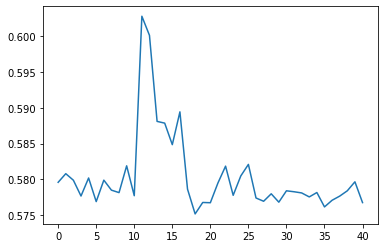

In [15]:
plt.plot(stim_prob_aucs[down_cols].mean(axis = 0).values)

In [16]:
sig_sp_positive = (up_95_conf_int.iloc[:, 10:18]>0.5).any(axis = 1)

In [17]:
def FR_diff_boxplots(sub_map, trial_types, times, colors, label_names):
    converted_times = (np.array(times)/0.025 + 1/0.025).astype(int)

    fig, axs = plt.subplots(1, 6, figsize = (22*size_mult,12*size_mult), sharey = True)
    plt.subplots_adjust(left=0.1, bottom=0.25, hspace = 0.02)
    pVals = []
    for t in range(len(converted_times[:-1])): 

        cropped_sub_map = sub_map.loc[:, trial_types].applymap(lambda y: np.nanmean(y[converted_times[t]: converted_times[t+1]]))

        pVals.append(scipy.stats.wilcoxon(cropped_sub_map[trial_types[0]].values,
                                          cropped_sub_map[trial_types[1]].values)[1])
        
        axs[t].set_title(f"{times[t]} to {times[t+1]} s")
        
        FR_change = cropped_sub_map[trial_types[0]].values - cropped_sub_map[trial_types[1]].values
        tt1_mean = cropped_sub_map[trial_types[0]].mean()
        tt2_mean = cropped_sub_map[trial_types[1]].mean()
        
        tt1_sem = cropped_sub_map[trial_types[0]].std()/np.sqrt(len(cropped_sub_map[trial_types[0]]))
        tt2_sem = cropped_sub_map[trial_types[1]].std()/np.sqrt(len(cropped_sub_map[trial_types[1]]))
        
        print(f"{tt1_mean} +/- {tt1_sem} vs {tt2_mean} +/- {tt2_sem}, p = {pVals[-1]}")
        
#         bp = ptitprince.half_violinplot(FR_change, ax = axs[t], orient = 'vertical', bw = 0.25, cut = 2, zorder = 0, offset = .5)
        sns.stripplot(FR_change, orient = 'vertical',size = 6, jitter = .35, ax = axs[t], zorder = 0, edgecolor = [0,0,0,1], linewidth = 1.5, color = colors[0], alpha = 0.5)
        bp = axs[t].boxplot(FR_change,positions = [-.55], showfliers= False, patch_artist = True)
        axs[t].axhline(0, color = 'k', linestyle = ':')

        for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)

        plt.setp(bp['medians'], color='k', linewidth = 1)

        max_val = max(FR_change)
        
        if pVals[-1]<0.05:
            color = 'g'
        else:
            color = 'k'
        axs[t].text(0.1, -35, f"p = {pVals[-1]:.1e}", color = color)
        axs[t].set_xticks([])
        axs[t].set_xticklabels([])


        axs[t].spines['right'].set_visible(False)
        axs[t].spines['top'].set_visible(False)
        axs[t].set_xlim(-.75,0.5)
    axs[0].set_ylabel('Firing Rate diffrence (Hz)\n(Touch Hit - Touch CR)')

    return fig, pVals

In [18]:
def FR_boxplots(sub_map, trial_types, times, colors, label_names):
    converted_times = (np.array(times)/0.025 + 1/0.025).astype(int)

    fig = plt.figure(figsize = (22*size_mult,8*size_mult))
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152,sharey= ax1)
    ax3 = fig.add_subplot(153,sharey= ax1)
    ax4 = fig.add_subplot(154,sharey= ax1)
    ax5 = fig.add_subplot(155,sharey= ax1)
    

    axs = [ax1,ax2,ax3,ax4, ax5]
    plt.subplots_adjust(left=0.1, bottom=0.25, hspace =0.025)

    pVals = []
    for t in range(len(converted_times[:-1])): 

        cropped_sub_map = sub_map.loc[:, trial_types].applymap(lambda y: np.nanmean(y[converted_times[t]: converted_times[t+1]]))

        pVals.append(scipy.stats.wilcoxon(cropped_sub_map[trial_types[0]].values,
                                          cropped_sub_map[trial_types[1]].values)[1])
        
        axs[t].set_title(f"{times[t]} - {times[t+1]}s")

        bp = axs[t].boxplot(cropped_sub_map.values, showfliers= False, patch_artist = True)

        for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)

        plt.setp(bp['medians'], color='w', linewidth = 3)

        max_val = max(np.array([cap.get_ydata() for cap in bp['caps']]).flatten())
        
        if pVals[-1]<0.05:
            color = 'g'
        else:
            color = 'k'
        axs[t].plot([1,2], [max_val + 1]*2, 'k')
        axs[t].text(1.25, max_val + 2, f"p = {pVals[-1]:.1e}", color = color)

        labels = axs[t].get_xticklabels()
        plt.setp(labels, rotation=70)
        axs[t].set_xticklabels(label_names)

        axs[t].spines['right'].set_visible(False)
        axs[t].spines['top'].set_visible(False)
    axs[0].set_ylabel('Firing Rate (Hz)')

    return fig, pVals

In [19]:
def plot_psth(time_window, arr, ax, color):
    time_window = np.array(time_window)
    x1, x2 = (np.array(time_window)/0.025 + 1/0.025).astype(int)
    x_range = np.arange(*time_window,bin_size)
    mean = arr.mean(axis = 0)[x1-1:x2-1] ## -1 to plot spike count at the end of bin for consistency across figs
    sem = scipy.stats.sem(np.vstack(arr.values)[:,x1:x2], axis = 0)
    ax.plot(x_range, mean, color = color)
    ax.fill_between(x_range, mean + sem, mean - sem, alpha = 0.5, color = color)
    

In [20]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)


In [21]:
unit_key_df['Touch Stim FA']

0       [16.666666666666668, 10.0, 0.0, 6.666666666666...
1       [3.3333333333333335, 3.3333333333333335, 3.333...
2       [13.333333333333334, 13.333333333333334, 16.66...
3       [3.3333333333333335, 10.0, 0.0, 3.333333333333...
4       [16.666666666666668, 6.666666666666667, 23.333...
                              ...                        
1534    [13.333333333333334, 12.307692307692308, 10.25...
1535    [7.17948717948718, 13.333333333333334, 13.3333...
1536    [7.17948717948718, 9.23076923076923, 8.2051282...
1537    [7.17948717948718, 14.35897435897436, 3.076923...
1538    [4.102564102564102, 2.051282051282051, 3.07692...
Name: Touch Stim FA, Length: 1539, dtype: object

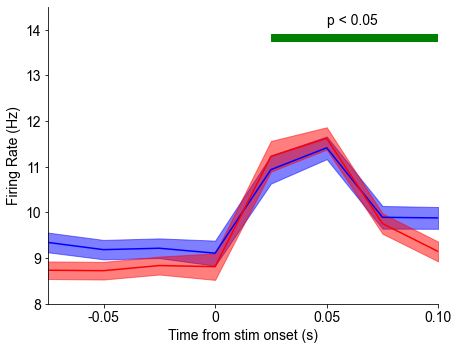

In [22]:
fig, ax = plt.subplots(1,1, figsize = (7,5))
sub_map = unit_key_df

plot_psth([-0.10, .125], sub_map['Touch Stim Miss'], ax, 'b')
# plot_psth([-0.1, .350], sub_map['Touch Stim Miss'], ax, [0.6,0.6,0.6])
plot_psth([-0.1, .125], sub_map['Touch Stim CR'], ax, 'r')
# plot_psth([-0.075, .350], sub_map['Touch Stim FA'], ax, 'r')


utils.prettify_ax(ax, x_label = 'Time from stim onset (s)', y_label = 'Firing Rate (Hz)')

rect = patches.Rectangle((.025,13.75), .075, .15,linewidth=1,edgecolor='g',facecolor='g')
ax.add_patch(rect)
ax.set_ylim(8,14.5)
ax.set_xlim(-.075,.1)
ax.set_xticks([-0.05, 0, 0.05, .1])
ax.set_xticklabels(['-0.05', '0', '0.05', '0.10'])
ax.text(0.05, 14.1, 'p < 0.05')

fig.subplots_adjust(top = .95)
# fig.savefig('early_FR_response.png', format='png')
# fig.savefig('early_FR_response.pdf', format='pdf')



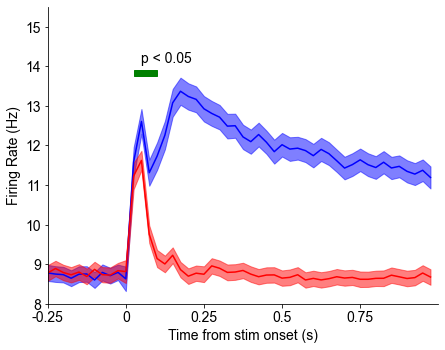

In [23]:
fig, ax = plt.subplots(1,1, figsize = (7,5))
sub_map = unit_key_df

plot_psth([-0.25, 1], sub_map['Touch Stim Hit'], ax, 'b')
plot_psth([-0.25, 1], sub_map['Touch Stim CR'], ax, 'r')

utils.prettify_ax(ax, x_label = 'Time from stim onset (s)', y_label = 'Firing Rate (Hz)')

rect = patches.Rectangle((.025,13.75), .075, .15,linewidth=1,edgecolor='g',facecolor='g')
ax.add_patch(rect)
ax.set_ylim(8,15.5)
ax.set_xlim(-.25,1.00)
ax.set_xticks([-0.25, 0, 0.25, 0.50, 0.75])
ax.set_xticklabels([-0.25, 0, 0.25, 0.50, 0.75])
ax.text(0.05, 14.1, 'p < 0.05')

fig.subplots_adjust(top = .95)
# fig.savefig('early_FR_response.png', format='png')
fig.savefig('early_FR_response.pdf(zoomed_out).pdf', format='pdf')

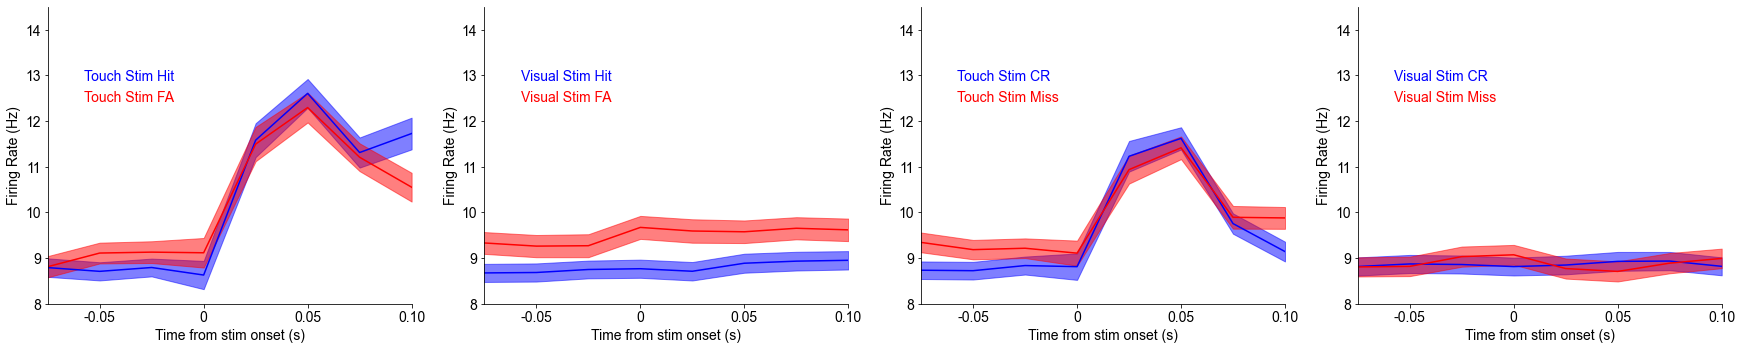

In [24]:
fig, axes = plt.subplots(1,4, figsize = (30,5))
sub_map = unit_key_df


trial_comparisons = [
    ('Touch Stim Hit','Touch Stim FA'),
    ('Visual Stim Hit','Visual Stim FA'),
    ('Touch Stim CR','Touch Stim Miss'),
    ('Visual Stim CR','Visual Stim Miss')
]
for ax, tts in zip(axes, trial_comparisons):
    plot_psth([-0.10, .125], sub_map[tts[0]], ax, 'b')
    plot_psth([-0.1, .125], sub_map[tts[1]], ax, 'r')

    utils.prettify_ax(ax, x_label = 'Time from stim onset (s)', y_label = 'Firing Rate (Hz)')

    ax.set_ylim(8,14.5)
    ax.set_xlim(-.075,.1)
    ax.set_xticks([-0.05, 0, 0.05, .1])
    ax.set_xticklabels(['-0.05', '0', '0.05', '0.10'])
    
    if "Touch" in sub_map[tts[0]]:
        tts[0] = tts[0].replace('Touch', 'Tactile')
        tts[1] = tts[1].replace('Touch', 'Tactile')
        
    ax.text(0.1, .75, tts[0], transform = ax.transAxes, color = 'b')
    ax.text(0.1, .68, tts[1], transform = ax.transAxes, color = 'r')


fig.subplots_adjust(top = .95)
# fig.savefig('early_FR_response.png', format='png')
fig.savefig('early_FR_response_block_comparisons.pdf', format='pdf')



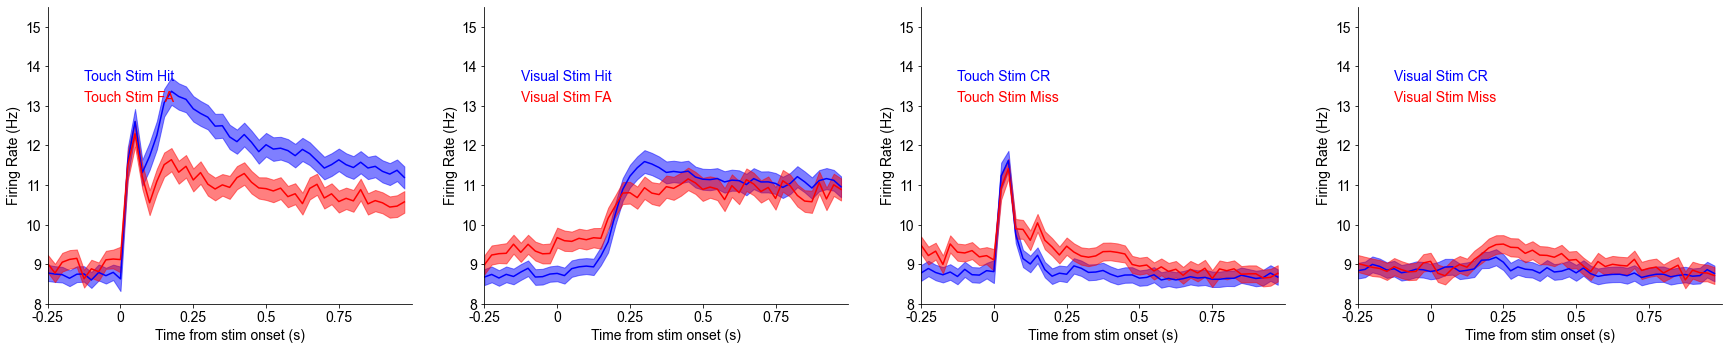

In [25]:
fig, axes = plt.subplots(1,4, figsize = (30,5))
sub_map = unit_key_df


trial_comparisons = [
    ('Touch Stim Hit','Touch Stim FA'),
    ('Visual Stim Hit','Visual Stim FA'),
    ('Touch Stim CR','Touch Stim Miss'),
    ('Visual Stim CR','Visual Stim Miss')
]
for ax, tts in zip(axes, trial_comparisons):
    plot_psth([-0.25, 1], sub_map[tts[0]], ax, 'b')
    plot_psth([-0.25, 1], sub_map[tts[1]], ax, 'r')

    utils.prettify_ax(ax, x_label = 'Time from stim onset (s)', y_label = 'Firing Rate (Hz)')

    ax.set_ylim(8,15.5)
    ax.set_xlim(-.25,1)
    ax.set_xticks([-0.25, 0, 0.25, 0.50, 0.75])
    ax.set_xticklabels([-0.25, 0, 0.25, 0.50, 0.75])
    
    
    if "Touch" in sub_map[tts[0]]:
        tts[0] = tts[0].replace('Touch', 'Tactile')
        tts[1] = tts[1].replace('Touch', 'Tactile')
        
    ax.text(0.1, .75, tts[0], transform = ax.transAxes, color = 'b')
    ax.text(0.1, .68, tts[1], transform = ax.transAxes, color = 'r')


fig.subplots_adjust(top = .95)
# fig.savefig('early_FR_response.png', format='png')
fig.savefig('early_FR_response_block_comparisons(zoomed_out).pdf', format='pdf')

In [26]:
sub_map['mouse_name'].unique()

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0084',
       'EF0088', 'EF0089', 'EF0114'], dtype=object)

8.794498333766587 +/- 0.19888934149299806 vs 8.836935454759702 +/- 0.19299151892560334, p = 0.6062220984113085
8.62942189001198 +/- 0.1946723368880844 vs 8.812730391542877 +/- 0.19658381253903923, p = 0.2706726380030229
11.581403178148571 +/- 0.3089973809190369 vs 11.22828623221561 +/- 0.28935331092637995, p = 0.027207878635820536
12.605053941167295 +/- 0.3708219748206264 vs 11.620588853024845 +/- 0.334975929035765, p = 7.419390625636971e-10
11.310421371475526 +/- 0.3148529437211511 vs 9.755646869340442 +/- 0.24296407040499143, p = 6.002914602829434e-11
11.726599780377803 +/- 0.329756633212402 vs 9.143055884859924 +/- 0.22240038850717164, p = 1.5232228974496298e-33


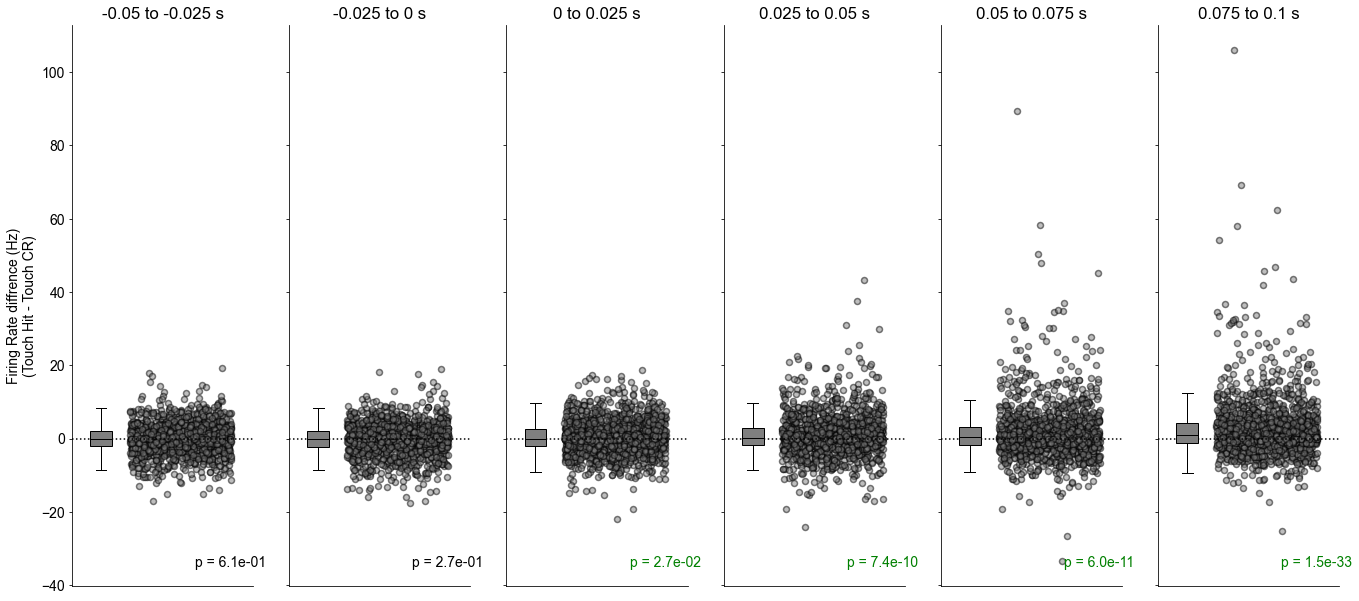

In [31]:
plt.close('all')
times = [-0.05, -0.025, 0, 0.025, .05, 0.075, 0.1]
colors = [ 'C7']
columns = ['Touch Stim Hit','Touch Stim CR']
labels = ['Touch Stim Hit','Touch Stim CR']

fig8d_1, pVals= FR_diff_boxplots(sub_map, columns, times, colors, labels)
# plt.gca().set_ylim(-2,45)
# plt.gca().set_xlim(-1,1)

fig8d_1.subplots_adjust(top = .9)

fig8d_1.savefig('early_FR_boxplots.png', format='png')
fig8d_1.savefig('early_FR_boxplots.pdf', format='pdf', dpi = 500)



In [20]:
sub_map

,uni_id,mouse_name,date,cluster_name,RT_mean_TLR,RT_mean_VLL,RT_median_TLR,RT_median_VLL,RT_std_TLR,RT_std_VLL,...,cp_onset_touch_LR_dp,area_under_cp_visual_LL_dp,max_cp_visual_LL_dp,cp_onset_visual_LL_dp,area_under_cp_touch_stim_sp,max_cp_touch_stim_sp,cp_onset_touch_stim_sp,area_under_cp_visual_stim_sp,max_cp_visual_stim_sp,cp_onset_visual_stim_sp
0,07401-03-161t1,EF0074,01-03-16,TT1clst1,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,0.244836,0.597762,NaN,0.077278,0.556132,NaN,-0.017950,0.575692,NaN
1,07401-03-162t1,EF0074,01-03-16,TT2clst1,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,-1.133391,0.547332,0.55,-0.012880,0.517686,NaN,-0.146410,0.489619,NaN
2,07401-03-162t2,EF0074,01-03-16,TT2clst2,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,0.884854,0.663511,NaN,0.153018,0.563245,NaN,-0.075260,0.624567,NaN
3,07401-03-165t1,EF0074,01-03-16,TT5clst1,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,0.844923,0.605336,NaN,-0.097078,0.511342,NaN,0.152682,0.647059,NaN
4,07401-03-165t2,EF0074,01-03-16,TT5clst2,0.415880,0.867735,0.329600,0.51465,0.198254,0.609469,...,NaN,-0.655508,0.612909,NaN,-0.028739,0.544983,NaN,0.001730,0.592128,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,11406-01-187t1,EF0114,06-01-18,TT7clst1,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,0.743171,0.607255,NaN,0.056793,0.559533,NaN,0.083333,0.666667,NaN
1535,11406-01-187t2,EF0114,06-01-18,TT7clst2,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,0.292264,0.576803,NaN,0.012053,0.539445,NaN,0.055556,0.666667,NaN
1536,11406-01-187t3,EF0114,06-01-18,TT7clst3,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,-0.094996,0.561464,NaN,0.018444,0.562820,NaN,0.430556,0.750000,NaN
1537,11406-01-188t1,EF0114,06-01-18,TT8clst1,0.889032,1.034190,0.441967,0.62510,0.820312,0.835476,...,NaN,0.548142,0.578370,NaN,0.031958,0.554785,NaN,0.222222,0.666667,NaN


In [32]:
plt.close('all')
times = [-0.025, 0, 0.025, .05, 0.75]
colors = [ 'C0', 'k']
columns = ['Touch Stim Hit','Touch Stim CR']
labels = ['Touch Stim Hit','Touch Stim CR']


In [33]:
sub_map.columns

Index(['uni_id', 'mouse_name', 'date', 'cluster_name', 'RT_mean_TLR',
       'RT_mean_VLL', 'RT_median_TLR', 'RT_median_VLL', 'RT_std_TLR',
       'RT_std_VLL', 'RT_num_TLR', 'RT_num_VLL', 'FR_mean', 'FR_std',
       'Touch Stim CR', 'Touch Stim FA', 'Touch Stim Hit', 'Touch Stim Miss',
       'Visual Stim CR', 'Visual Stim FA', 'Visual Stim Hit',
       'Visual Stim Miss', 'Touch Stim Hit(z_score)', 'Touch Stim CR(z_score)',
       'Touch Stim Miss(z_score)', 'Touch Stim FA(z_score)',
       'Visual Stim Hit(z_score)', 'Visual Stim CR(z_score)',
       'Visual Stim Miss(z_score)', 'Visual Stim FA(z_score)',
       'activation_resp_touch', 'activation_resp_vis', 'act_resp',
       'center_mass_touch', 'area_under_cp_touch_LR_dp', 'max_cp_touch_LR_dp',
       'cp_onset_touch_LR_dp', 'area_under_cp_visual_LL_dp',
       'max_cp_visual_LL_dp', 'cp_onset_visual_LL_dp',
       'area_under_cp_touch_stim_sp', 'max_cp_touch_stim_sp',
       'cp_onset_touch_stim_sp', 'area_under_cp_visual_stim_